In [319]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tools.eval_measures import rmse
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

Weekly Receiver Stats

In [320]:
weekly = nfl.clean_nfl_data(nfl.import_weekly_data(range(2012, 2023)))
snap_counts = nfl.clean_nfl_data(nfl.import_snap_counts(range(2012, 2023)))
ids = nfl.clean_nfl_data(nfl.import_ids())
ngs = nfl.clean_nfl_data(nfl.import_ngs_data('receiving'))

Downcasting floats.


In [321]:
ngs.columns

Index(['season', 'season_type', 'week', 'player_display_name',
       'player_position', 'team_abbr', 'avg_cushion', 'avg_separation',
       'avg_intended_air_yards', 'percent_share_of_intended_air_yards',
       'receptions', 'targets', 'catch_percentage', 'yards', 'rec_touchdowns',
       'avg_yac', 'avg_expected_yac', 'avg_yac_above_expectation',
       'player_gsis_id', 'player_first_name', 'player_last_name',
       'player_jersey_number', 'player_short_name'],
      dtype='object')

In [322]:
snap_counts = pd.merge(snap_counts[['season', 'week', 'pfr_player_id', 'game_id', 'offense_pct']], ids[['gsis_id', 'pfr_id']], left_on=['pfr_player_id'], right_on=['pfr_id'])

In [323]:
df = pd.merge(weekly, snap_counts, left_on=['season', 'week', 'player_id'], right_on=['season', 'week', 'gsis_id'], how='left')
df.shape

(55104, 57)

In [324]:
df = pd.merge(df, ngs, left_on=['season', 'week', 'player_id'], right_on=['season', 'week', 'player_gsis_id'], how='left', suffixes=('', '_ngs'))
df.shape

(55104, 78)

In [325]:
df.head()

,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,...,yards,rec_touchdowns,avg_yac,avg_expected_yac,avg_yac_above_expectation,player_gsis_id,player_first_name,player_last_name,player_jersey_number,player_short_name
0,00-0000865,None,Charlie Batch,QB,QB,None,PIT,2012,12,REG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00-0000865,None,Charlie Batch,QB,QB,None,PIT,2012,13,REG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00-0004541,None,Donald Driver,WR,WR,None,GB,2012,2,REG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00-0004541,None,Donald Driver,WR,WR,None,GB,2012,3,REG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00-0004541,None,Donald Driver,WR,WR,None,GB,2012,4,REG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Receiving Stats

In [326]:
receiving = df[(df['position_group'] == 'WR') & (df['offense_pct'] > 0)].copy()
receiving['y'] = receiving['receiving_yards']
receiving.shape

(17970, 79)

In [327]:
weekly_cols = ['receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_yards_after_catch', 'receiving_air_yards', 'receiving_epa', 'racr', 'target_share', 'air_yards_share', 'wopr', 'offense_pct']
ngs_cols = ['avg_cushion', 'avg_separation', 'avg_intended_air_yards', 'percent_share_of_intended_air_yards', 'catch_percentage', 'avg_yac', 'avg_expected_yac', 'avg_yac_above_expectation']
receiving_cols = weekly_cols + ngs_cols

In [328]:
receiving.dropna(axis=0, subset=receiving_cols, how='all', inplace=True)
receiving.fillna(0, inplace = True)
receiving.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17970 entries, 2 to 54938
Data columns (total 79 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   player_id                            17970 non-null  object 
 1   player_name                          17970 non-null  object 
 2   player_display_name                  17970 non-null  object 
 3   position                             17970 non-null  object 
 4   position_group                       17970 non-null  object 
 5   headshot_url                         17970 non-null  object 
 6   recent_team                          17970 non-null  object 
 7   season                               17970 non-null  int32  
 8   week                                 17970 non-null  int32  
 9   season_type                          17970 non-null  object 
 10  completions                          17970 non-null  int32  
 11  attempts                    

In [329]:
for col in receiving_cols:
    receiving[col] = receiving.groupby(['player_id', 'season'])[col].transform(lambda x: x.shift().expanding(min_periods=1).mean())
receiving.dropna(axis=0, subset=receiving_cols, how='all', inplace=True)
receiving.shape

(16258, 79)

In [330]:
receiving = receiving[receiving_cols + ['game_id', 'recent_team', 'y']]
receiving.head(5)

,receptions,targets,receiving_yards,receiving_tds,receiving_yards_after_catch,receiving_air_yards,receiving_epa,racr,target_share,air_yards_share,...,avg_separation,avg_intended_air_yards,percent_share_of_intended_air_yards,catch_percentage,avg_yac,avg_expected_yac,avg_yac_above_expectation,game_id,recent_team,y
3,1.000000,1.000000,26.000000,1.000000,2.000000,24.0,2.862955,1.083333,0.031250,0.107143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012_03_GB_SEA,GB,0.0
4,0.500000,1.000000,13.000000,0.500000,1.000000,17.0,0.844883,0.541667,0.028783,0.079613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012_04_NO_GB,GB,3.0
5,0.666667,1.333333,9.666667,0.333333,0.666667,16.0,0.422192,0.432540,0.035449,0.067523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012_05_GB_IND,GB,14.0
6,0.750000,1.500000,10.750000,0.250000,0.750000,18.5,0.266665,0.459020,0.042716,0.076233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012_07_GB_STL,GB,2.0
7,0.800000,1.400000,9.000000,0.200000,0.800000,15.0,-0.032163,0.767216,0.039728,0.061602,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012_08_JAX_GB,GB,10.0


In [331]:
receiving.describe()

,receptions,targets,receiving_yards,receiving_tds,receiving_yards_after_catch,receiving_air_yards,receiving_epa,racr,target_share,air_yards_share,...,offense_pct,avg_cushion,avg_separation,avg_intended_air_yards,percent_share_of_intended_air_yards,catch_percentage,avg_yac,avg_expected_yac,avg_yac_above_expectation,y
count,16258.000000,16258.000000,16258.000000,16258.000000,16258.000000,16258.000000,16258.000000,16258.000000,16258.000000,16258.000000,...,16258.000000,16258.000000,16258.000000,16258.000000,16258.000000,16258.000000,16258.000000,16258.000000,16258.000000,16258.000000
mean,3.434586,5.537830,44.690517,0.275438,15.084137,60.626778,1.362095,0.938761,0.160634,0.212827,...,0.646099,2.044372,0.967713,3.874060,10.417320,21.827557,1.525843,1.396259,0.128642,44.100197
std,1.921694,2.815173,27.076113,0.298122,11.390921,35.856239,2.206287,1.140175,0.079363,0.119836,...,0.237978,2.330379,1.128322,4.704683,13.325048,25.601268,2.060290,1.771960,0.714345,38.819004
min,0.000000,0.000000,-7.000000,0.000000,-5.000000,-14.000000,-17.873531,-1.000000,0.000000,-0.065421,...,0.010000,0.000000,0.000000,-0.460179,-1.638364,0.000000,-2.340000,-1.019344,-5.331798,-12.000000
25%,2.000000,3.285714,23.600000,0.000000,6.750000,32.900002,0.032138,0.606987,0.096910,0.119705,...,0.482500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000
50%,3.200000,5.307692,41.888889,0.214286,13.000000,57.000000,1.175541,0.812775,0.155840,0.203798,...,0.700000,0.914762,0.394559,1.368791,2.915816,8.333333,0.326007,0.399148,0.000000,35.000000
75%,4.714286,7.500000,62.000000,0.428571,21.125000,84.724026,2.553323,1.068822,0.218750,0.298452,...,0.842727,4.121095,1.901482,7.463941,19.349751,43.649684,2.760057,2.599072,0.129934,65.000000
max,16.000000,19.000000,208.000000,3.000000,134.000000,282.000000,18.739258,90.000000,0.521739,0.783333,...,1.000000,9.985714,7.018691,33.932000,75.642905,100.000000,29.235000,21.648874,11.210653,329.000000


Statistical Relevance

In [332]:
receiving['outl'] = 0
for col in receiving_cols + ['y']:
    receiving[f'z_{col}'] = np.abs(stats.zscore(receiving[col]))
    receiving[f'outl_{col}'] = np.where(receiving[f'z_{col}'] >= 3, 1, 0)
    receiving['outl'] = np.where(receiving['outl'], receiving['outl'], receiving[f'outl_{col}'])
    outl = list(np.where(np.abs(receiving[f'z_{col}']) > 3)[0])
    print(f"Total outlier {col}: ", len(outl), "\n")

Total outlier receptions:  69 

Total outlier targets:  56 

Total outlier receiving_yards:  74 

Total outlier receiving_tds:  144 

Total outlier receiving_yards_after_catch:  188 

Total outlier receiving_air_yards:  84 

Total outlier receiving_epa:  208 

Total outlier racr:  101 

Total outlier target_share:  32 

Total outlier air_yards_share:  42 

Total outlier wopr:  27 

Total outlier offense_pct:  0 

Total outlier avg_cushion:  8 

Total outlier avg_separation:  51 

Total outlier avg_intended_air_yards:  79 

Total outlier percent_share_of_intended_air_yards:  71 

Total outlier catch_percentage:  27 

Total outlier avg_yac:  175 

Total outlier avg_expected_yac:  141 

Total outlier avg_yac_above_expectation:  332 

Total outlier y:  184 



In [333]:
print(receiving.shape)
receiving = receiving[receiving['outl'] == 0]
print(receiving.shape)

(16258, 66)
(14993, 66)


Text(0.5, 1.0, 'Correlation Between Variables')

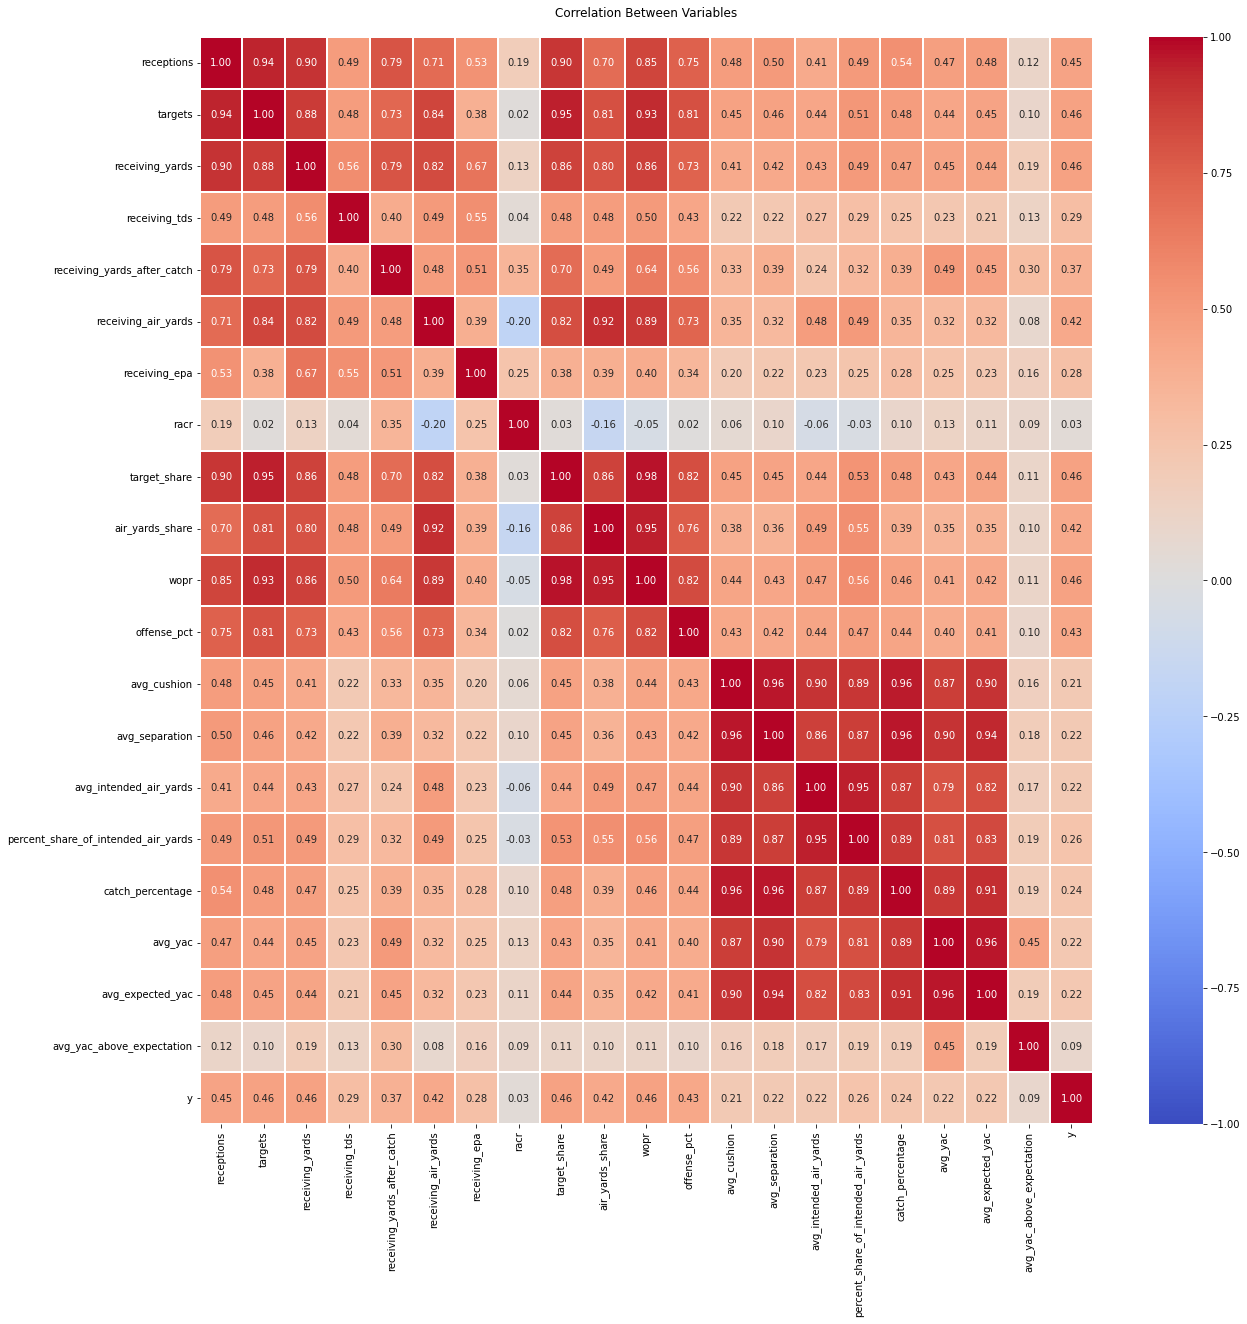

In [334]:
corr = receiving[receiving_cols + ['y']].corr()
plt.figure(figsize = (20, 20))
sns.heatmap(corr, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

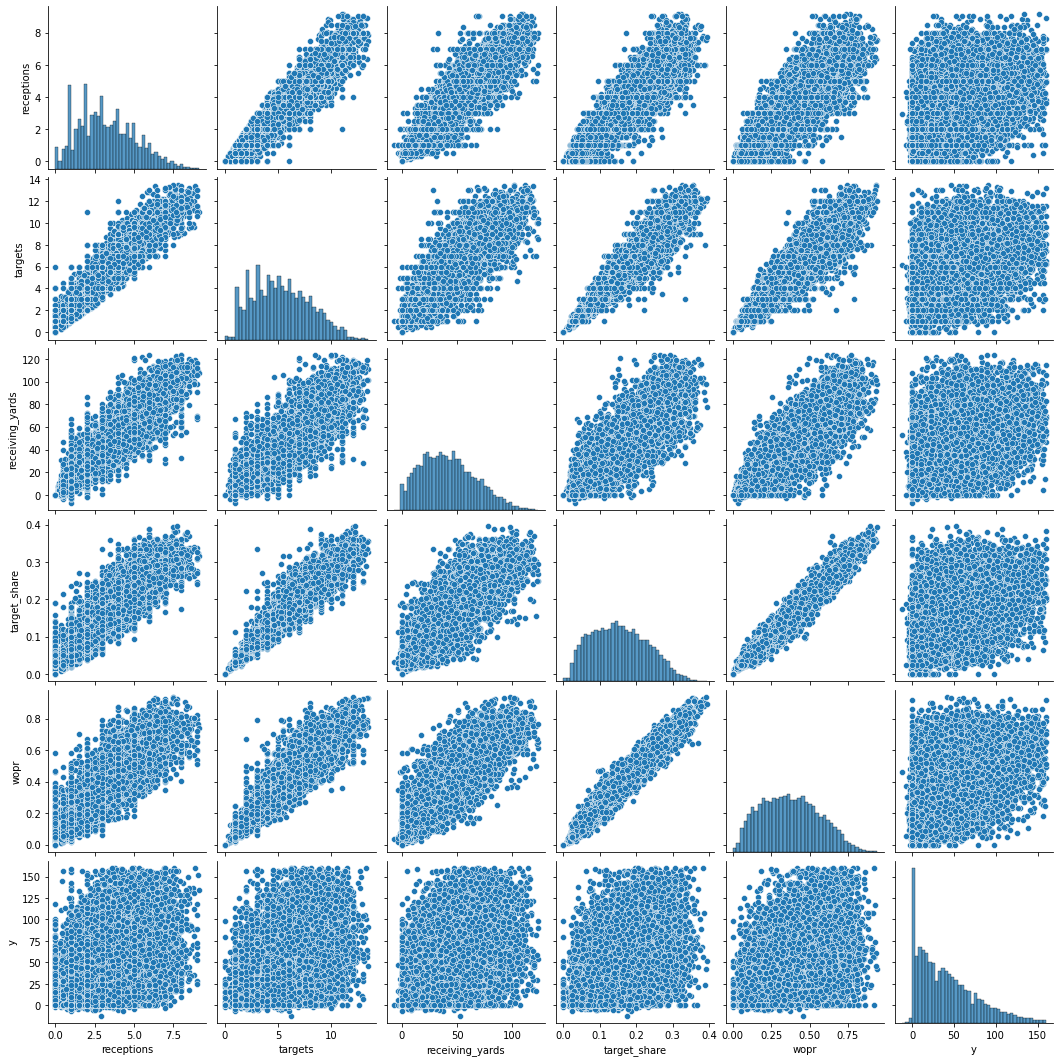

In [335]:
cols = [col for col in receiving_cols if receiving[col].corr(receiving['y']) >= .45] + ['y']
df = receiving[cols].reset_index(drop=True)
sns.pairplot(df[cols])

<AxesSubplot:>

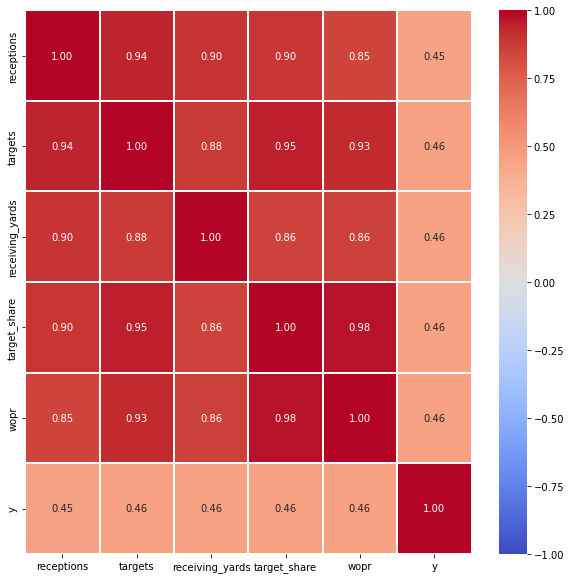

In [336]:
corr = df.corr()
plt.figure(figsize = (10, 10))
sns.heatmap(corr, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)

In [337]:
X = df.iloc[:, :-1]
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))
y = df.iloc[:, -1:]
scores=[] #to store r squared
rmse_list=[] #to store RMSE
lrmodel = LinearRegression()
cv = KFold(n_splits=10, random_state=42, shuffle=True, )
for train_index, test_index in cv.split(X):
    X_train = X.loc[train_index, :]
    X_test = X.loc[test_index,  :] 
    y_train = y.loc[train_index, :]
    y_test = y.loc[test_index, :]

    lrmodel.fit(X_train, y_train)
    y_predict = lrmodel.predict(X_test)
    scores.append(lrmodel.score(X_test, y_test))
    rmse_fold = rmse(y_test, y_predict)
    rmse_list.append(rmse_fold)

In [338]:
lm = smf.ols(formula='y ~ receptions + targets + target_share', data = df).fit()
comparison = pd.DataFrame({"y_test": [y_test], "y_predict": [y_predict]})
print("Summary: ", lm.summary())
print("R Squared Mean: ", np.mean(scores))
print("RMSE mean: ", np.mean(rmse_list))

Summary:                              OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     1402.
Date:                Tue, 11 Oct 2022   Prob (F-statistic):               0.00
Time:                        21:25:20   Log-Likelihood:                -72906.
No. Observations:               14993   AIC:                         1.458e+05
Df Residuals:                   14989   BIC:                         1.459e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        8.2719      0.583    